In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from IPython.display import Image
from scipy import stats
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

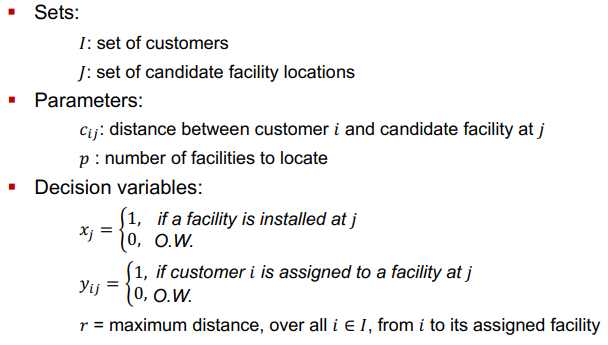

In [3]:
# display the variables
Image(filename='variables.png')

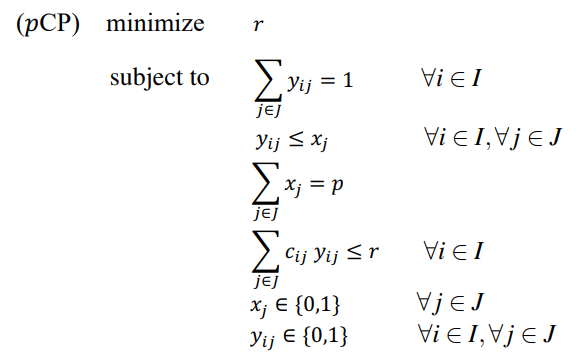

In [4]:
# display the model
Image(filename='model.png')

In [5]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
j_data = pd.read_excel('data.xlsx', sheet_name='j_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [6]:
# declare the parameters and sets
I = [i for i in range(len(i_data['X'].values))]
J = [j for j in range(len(j_data['X'].values))]
A = [(i, j) for i in I for j in J]

p = 3
c = {(i, j): dist_ij[i, j] for (i, j) in A}

In [7]:
# create model
mdl = Model('pCP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [8]:
# add model variables
x = mdl.addVars(J, vtype=GRB.BINARY)
y = mdl.addVars(A, vtype=GRB.BINARY)
r = mdl.addVar()

In [9]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(r)

In [10]:
# add the model constraints
mdl.addConstrs(quicksum(y[i,j] for j in J) == 1 for i in I)
mdl.addConstrs(y[i,j] <= x[j] for i,j in A)
mdl.addConstr(quicksum(x[j] for j in J) == p)
mdl.addConstrs(quicksum(c[i,j]*y[i,j] for j in J) <= r for i in I)
mdl.update()

In [11]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 2201 rows, 2021 columns and 8120 nonzeros
Model fingerprint: 0xc174cbfb
Variable types: 1 continuous, 2020 integer (2020 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve time: 0.01s
Presolved: 2201 rows, 2021 columns, 7766 nonzeros
Variable types: 1 continuous, 2020 integer (2020 binary)
Found heuristic solution: objective 124.8818739

Root relaxation: objective 7.090698e+01, 1142 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   70.90698    0  431  124.88187   70.90698  43.2%     -    0s
H    0     0                     123.7753527   70.90698  42.7%     -    0s
H    0

In [12]:
# opened locations and covered customers
opened = [j for j in J if x[j].X > 0.0]
covered = [a for a in A if y[a].X > 0.0]

In [13]:
# update the dataframes
j_data['Opened'] = [int(x[j].X > 0.0) for j in J]
i_data['Covered'] = [int(any(y[i,j].X > 0.0 for j in J)) for i in I]
i_data['Facility'] = [j for i,j in A if y[i,j].X > 0.0]

Text(0.5, 1.0, 'Facilities Chosen')

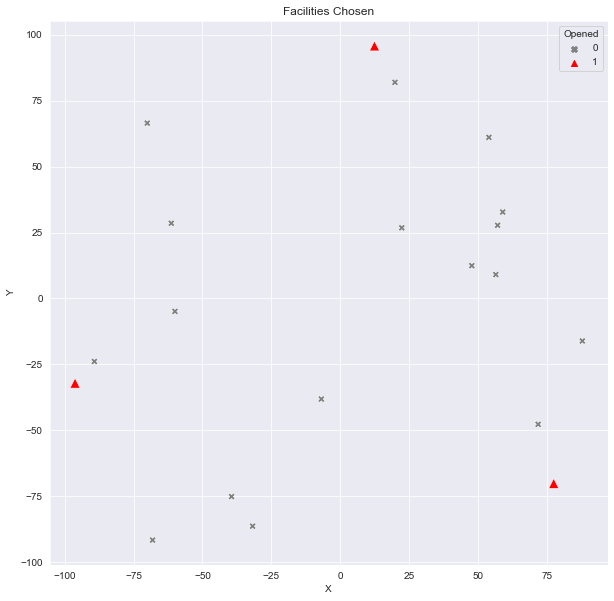

In [14]:
# plot the station locations
fig, ax = plt.subplots(figsize=(10,10))
s = [100 if i == 1 else 50 for i in j_data['Opened'].values]
sns.scatterplot(x='X', y='Y', data=j_data, hue='Opened', palette=['grey', 'red'], style='Opened', markers=('X', '^'), s=s)
plt.title('Facilities Chosen')

Text(0.5, 1.0, 'Facility Coverage')

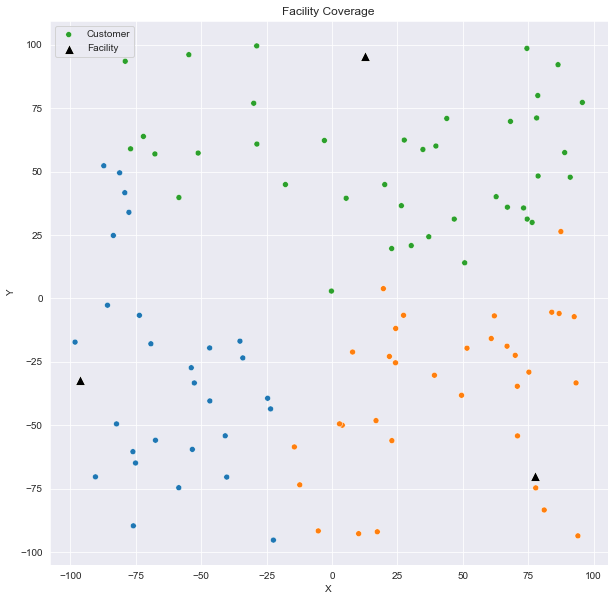

In [15]:
# plot the customer coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=i_data, hue='Facility', palette='tab10', s=35, legend=False, label="Customer")
sns.scatterplot(x='X', y='Y', data=j_data[j_data['Opened'] == 1], s=100, color='black', marker='^', label="Facility")
plt.title('Facility Coverage')

In [16]:
# find objective value
obj_val = r.X

print('Objective value = ', obj_val)

Objective value =  97.20674686935553
